# Beamforming Basics

Taken from Aishwarya Selvaraj to simulate MWA/CRAM Beam tiles from the ground up. Modified to a jupyter notebook for pedagogical purposes.

It is reccomended that you read: Thompson, A.R., Moran, J.M. and Swenson Jr., G.W. (2017) Interferometry and synthesis in radio astronomy. Third edition. Cham: Springer Open (Astronomy and astrophysics library).

## Part 0: Setup

In [2]:
from __future__ import print_function, division
import os
import matplotlib.colors as colors
import matplotlib.pylab as plt
from scipy import interpolate
from matplotlib import cm
import numpy as np
import xlrd
from mpl_toolkits.mplot3d import axes3d, Axes3D

save_results_to = './interferometry practice'

## Part 1: 1-D Beamforming

### 1.1: The Simplest Case - Monochromatic Beamforming with Equidistant Baselines

First, we consider a 1-dimensional array of equidistantly spaced radio antennas, all arranged on an East-West baseline (no parallel component to the rotation axis of the Earth). We also observe a single frequency of radiation.

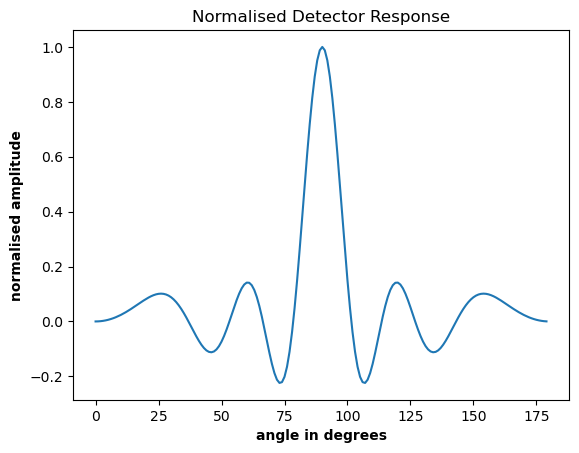

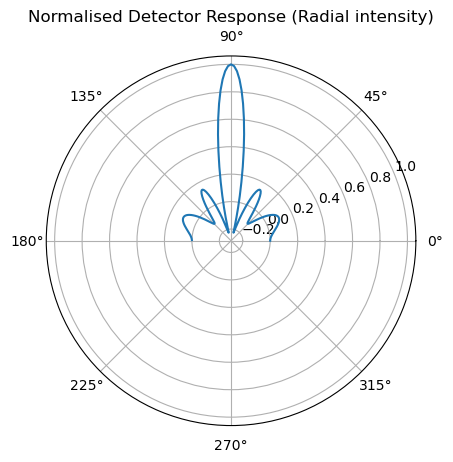

In [3]:
angle = np.arange(0, 180) # FOV covers horizon to horizon. 
theta = np.deg2rad(angle) 

f = (150*10**6) # 150 MHz Frequency = 2 meters (21 cm at redshift z = 8.52)
lamda = ((3*10**8)/f)
k = (2*np.pi/lamda)
d = lamda/2
l = np.cos(theta)

delta = 0 # phase difference of one source with respect to another. 
chi = k*d*l  + delta # total phase difference.

n = 10 # number of detectors
af = (np.sin(n*chi/2))/(n*np.sin(chi/2)) # normalised array factor.

plt.figure()
plt.plot(angle, af)
plt.title("Normalised Detector Response")
plt.xlabel('angle in degrees', fontweight ='bold')
plt.ylabel('normalised amplitude', fontweight ='bold')
plt.show()

plt.figure()
plt.polar(theta, af)
plt.title("Normalised Detector Response (Radial intensity)")
plt.show()

Next we can display the FWHM of the central fringe.

13.912835880252544 9.697527000150108
0.2448945100886457


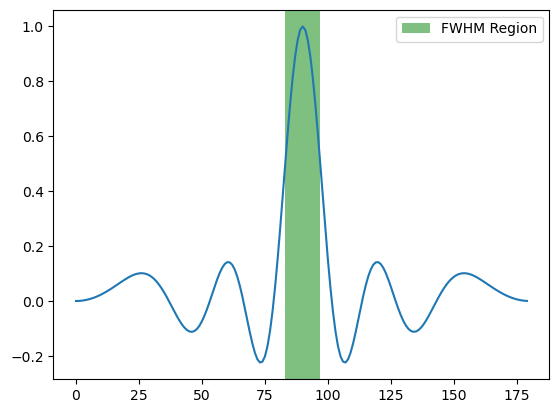

In [4]:
from scipy.interpolate import UnivariateSpline
from scipy import integrate
import pylab as pl
signal = af
spline = UnivariateSpline(angle, signal - np.max(signal)/2, s=0)
r1, r2 = spline.roots()
FWHM = (r2-r1)
sigma = np.deg2rad(FWHM)/2.3548
print(FWHM, 1/(sigma))
area = integrate.simps(signal, angle )
print(np.deg2rad(area))
plt.plot(angle, signal)
plt.axvspan(r1, r2, facecolor = 'g', alpha = 0.5, label="FWHM Region")
plt.legend()
plt.show()

We can now look at how the number of detectors affects the prescision of the primary fringe for a point source.

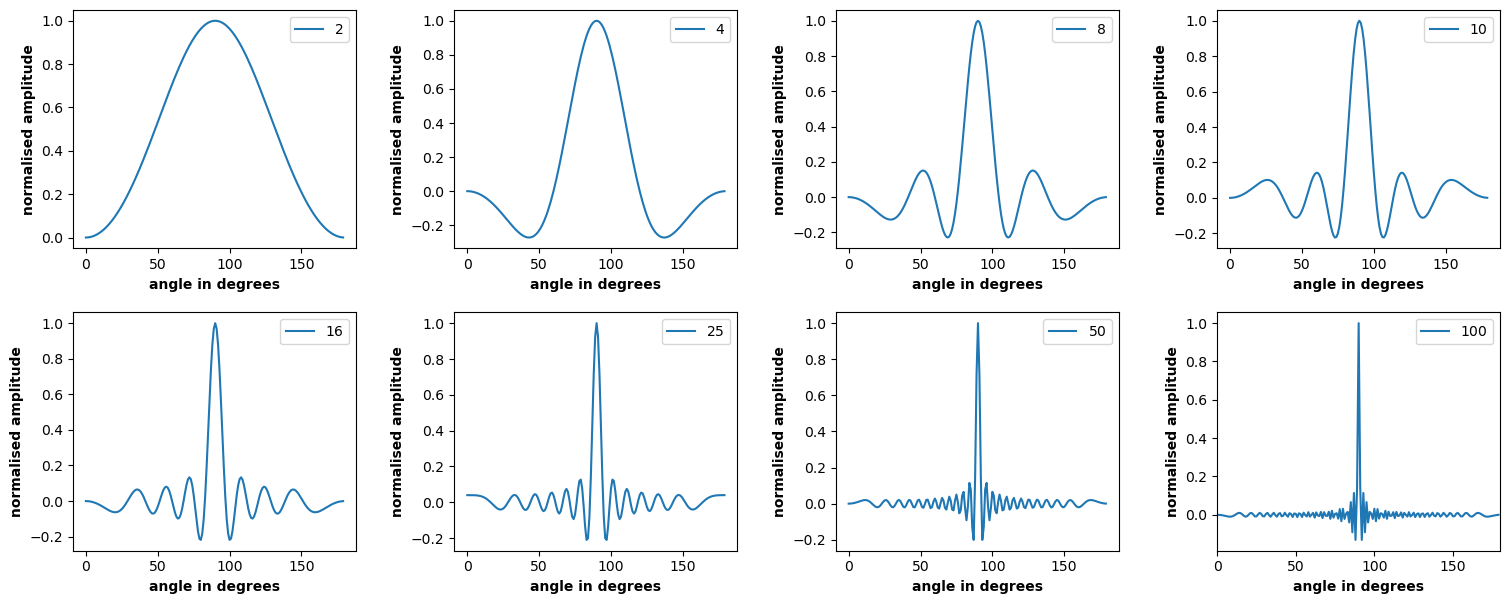

In [5]:
fig, axs = plt.subplots(2, 4, figsize=(15, 6))
fig.tight_layout(w_pad=4, h_pad=2.5)
plt.xlim(angle[0], angle[-1]+1)
N = [2, 4, 8, 10, 16, 25, 50, 100]
count = 0
for row in range(2):
    for col in range(4):
        n = N[count]
        af = (np.sin(n*chi/2))/(n*np.sin(chi/2))
        axs[row, col].plot(angle, af)
        axs[row, col].legend(["$" + str(n) + "$"], loc ="best")
        count = count+1
        axs[row, col].set_xlabel('angle in degrees', fontweight ='bold')
        axs[row, col].set_ylabel('normalised amplitude', fontweight ='bold')

### 1.2: Random Detector Spacings

We now consider a random distribution of detectors. Now that the distribution is no-longer symmetric we cannot expect the complex signal to be symmetric either. So we have to consider the full complex plane.

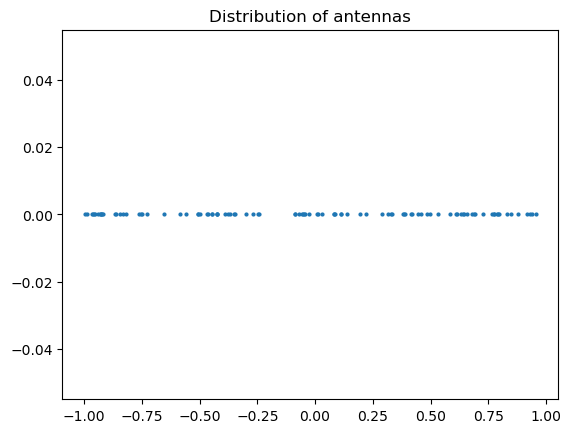

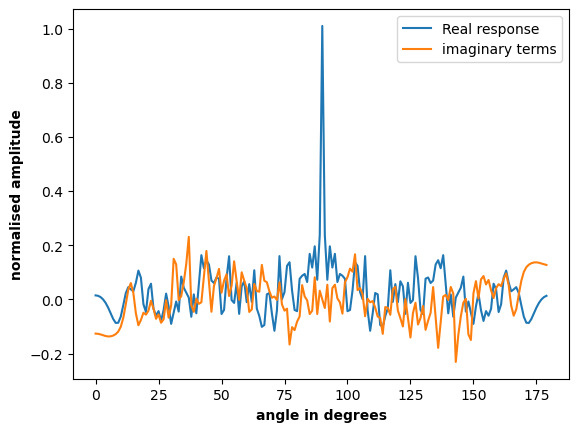

In [6]:
angle = np.arange(0, 180) # FOV covers horizon to horizon. 
theta = np.deg2rad(angle) 

f = (150*10**6) 
lamda = ((3*10**8)/f)
beta = (2*np.pi/lamda)
n = 100
scale_distance = lamda
d = scale_distance*(np.random.rand(n)-0.5)

plt.title("Distribution of antennas")
plt.plot(d, np.zeros(n), 'o', markersize=2)
plt.show()

l = np.cos(theta)

delta = 0
chi = beta*np.array([l * dn for dn in d]) + delta # total phase difference

af = 1

for i in range(n):
    chin = chi[i]
    af = af + np.exp(1j*(i+1)*chin)

af = af/n


plt.plot(angle, np.real(af))
plt.plot(angle, np.imag(af))
plt.legend(['Real response', 'imaginary terms'],  loc ="upper right")
plt.xlabel('angle in degrees', fontweight ='bold')
plt.ylabel('normalised amplitude', fontweight ='bold')
plt.show()

Note that as we increase the density of detectors, we increase the effective overlap, and remove the random elements from the signal, as well as the imaginary component, which takes the shape of a multiplicity-three peak.

### 2.3: 1-D Ground Plane Effect

Now we consider the effect of the ground plane in 1 dimension. The ground plane is the flooring that MWA tiles use to remove radio signals emitted through the Earth itself. It acts as an insulator that allows telescopes to focus-in on the sky.

Note that now, we shift our centering angle to be at $0^{\circ}$, so that the full range will be from $[-90^{\circ}, 90^{\circ}]$ instead.

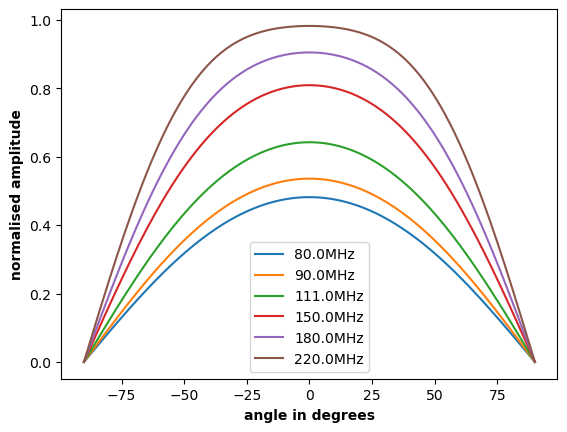

In [7]:
angle = np.arange(-90, 90+1) 
theta = np.deg2rad(angle)
f = [80*10**6, 90*10**6, 111*10**6, 150*10**6, 180*10**6, 220*10**6]

antenna_height = 0.3 # The height of the antenna above the ground plane

plt.figure()
for k in range(len(f)):
    lamda = ((3*10**8)/f[k])
    h = antenna_height/lamda # Convert to no. of wavelengths
    l = np.cos(theta)
    pf = np.sin(2*h*np.pi*l) # Ground plane effect equation
    # The total_voltage is equal to: af*pf
    plt.plot(angle, pf, label = str(f[k]/10**6) + "MHz")
    plt.legend()

plt.xlabel('angle in degrees', fontweight ='bold')
plt.ylabel('normalised amplitude', fontweight ='bold') 

plt.show()

As you can see, the ground plane effect is frequency-dependent. This is something that we need to account for when analysing with a range of frequencies.

Let's now apply this to our random distribution of antennas.

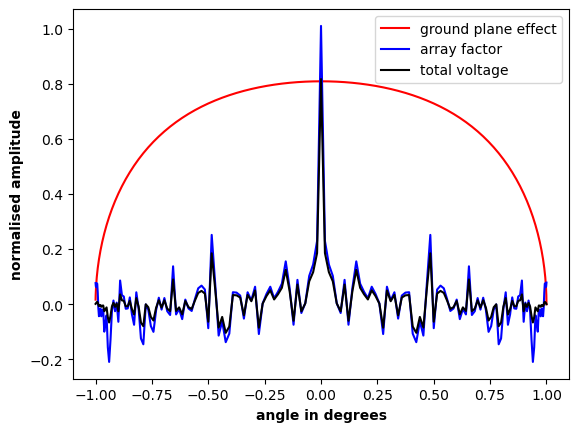

In [8]:
angle = np.arange(0, 180) # FOV covers horizon to horizon. 
theta = np.deg2rad(angle) 

f = (150*10**6) 
lamda = ((3*10**8)/f)
beta = (2*np.pi/lamda)
n = 100
scale_distance = lamda
d = scale_distance*np.random.rand(n)
l = np.cos(theta)

delta = 0
chi = beta*np.array([l * dn for dn in d]) + delta # total phase difference

af = 1

for i in range(n):
    chin = chi[i]
    af = af + np.exp(1j*(i+1)*chin)

af = np.real(af/n)

antenna_height = 0.3 # The height of the antenna above the ground plane
angle = np.arange(-90, 90)
theta = np.deg2rad(angle)
h = antenna_height/lamda
element_pattern = np.sin(2*h*np.pi*np.cos(theta)) # Ground plane effect

total_voltage = af*element_pattern

plt.plot(l, element_pattern, 'r')
plt.plot(l, af, 'b') 
plt.plot(l, total_voltage, 'k')
plt.xlabel('angle in degrees', fontweight ='bold')
plt.ylabel('normalised amplitude', fontweight ='bold')
plt.legend(['ground plane effect', 'array factor', 'total voltage'], loc ="best")
plt.show()

### 2.4 Multiple discreet frequencies

Typically when performing observations over a range of frequencies, the data output gains an additional dimension representing the observed frequency of light. We are capable of binning frequencies in a radio telescope array by 'tuning into' a different frequency at a time, using the same mechanism that most radio communication devices use to detect radio waves at specific frequencies. The exact nature of this process is beyond the scope of this python notebook.

## Part 2: 2-D Beamforming

### 2.1: Placing our 1-D antenna array into 2-D space

We first consider our linear array of antennas and see what they would observe if placed in a real-world situation where there are two dimensions on Earth's surface. 

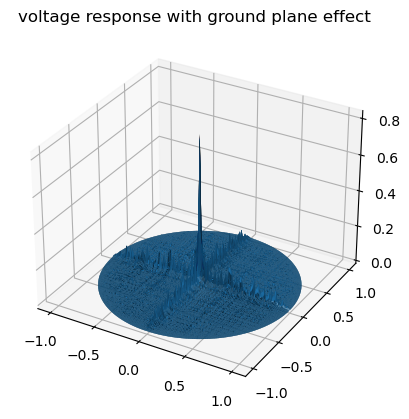

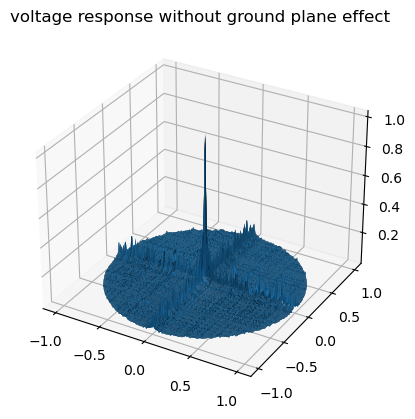

In [9]:
theta = np.deg2rad(np.arange(-90, 90))
phi = np.deg2rad(np.arange(-180, 180))
[theta, phi] = np.meshgrid(theta, phi)

f = (150*10**6) 
lamda = ((3*10**8)/f)
beta = (2*np.pi/lamda)
n = 100
scale_distance = lamda
d = scale_distance*(np.random.rand(n)-0.5)

l = np.sin(theta)*np.cos(phi)
m = np.sin(phi)*np.sin(theta)

delta = [0, 0] # Phase difference is now 2D

# We now consider things in two dimensions
chix = beta*np.array([l * dn for dn in d]) + delta[0]  # X-phase difference
chiy = beta*np.array([m * dn for dn in d]) + delta[1]  # Y-phase difference

afx = 1
afy = 1

for i in range(n):
    chinx = chix[i]
    chiny = chiy[i]

    afx = afx + np.exp(1j*(i+1)*chinx)
    afy = afy + np.exp(1j*(i+1)*chiny)

af = abs(afx*afy)/n**2

# Ground plane effect
antenna_height = 0.3
h = antenna_height/lamda
ground_plane_effect = np.sin(2*h*np.pi*np.cos(theta))

total_voltage = af*ground_plane_effect

# 3D plot of voltage response with the ground plane effect
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(l, m, total_voltage, rstride=1, cstride=1, antialiased=True)
plt.title('voltage response with ground plane effect')
plt.show()


# 3D plot of voltage response without the ground plane effect 
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(l, m, af, rstride=1, cstride=1, antialiased=True)
plt.title('voltage response without ground plane effect')
plt.show()


### 2.2: Randomly distributed points

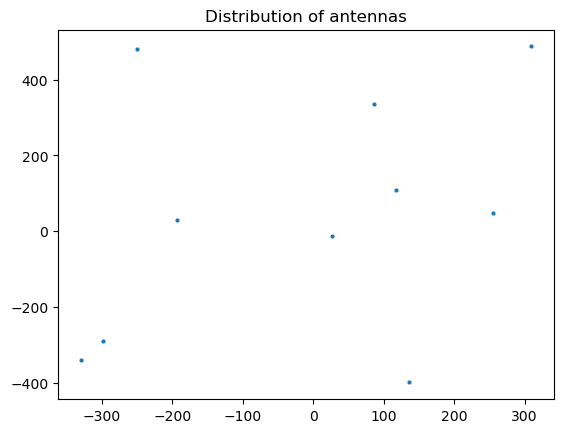

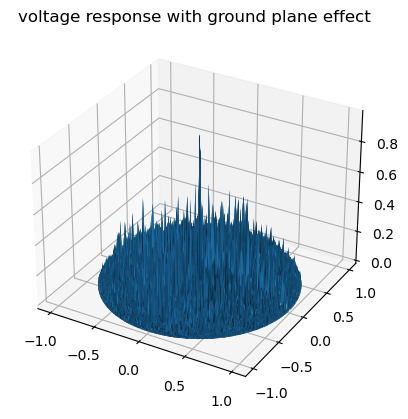

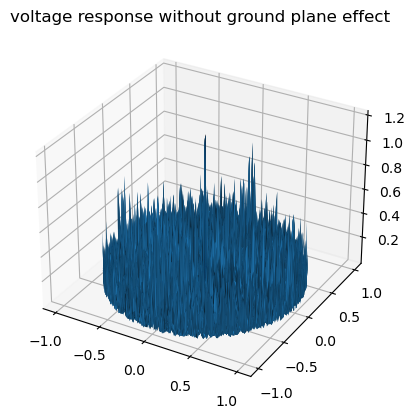

In [10]:
theta = np.deg2rad(np.arange(-90, 90))
phi = np.deg2rad(np.arange(-180, 180))
[theta, phi] = np.meshgrid(theta, phi)

f = (150*10**6) 
lamda = ((3*10**8)/f)
beta = (2*np.pi/lamda)

# Create n antenna locations for a single detector, using u, v coordinates
n = 10
scale_distance = 1000
u = scale_distance*(np.random.rand(n) - 0.5)
v = scale_distance*(np.random.rand(n) - 0.5)

plt.title("Distribution of antennas")
plt.plot(u, v, 'o', markersize=2)
plt.show()

l = np.sin(theta)*np.cos(phi)
m = np.sin(phi)*np.sin(theta)

delta = [0, 0] # Phase difference is now 2D

# We now consider things in two dimensions
chix = beta*np.array([l * dn for dn in u]) + delta[0]  # X-phase difference
chiy = beta*np.array([m * dn for dn in v]) + delta[1]  # Y-phase difference

afx = 1
afy = 1

for i in range(n):
    chinx = chix[i]
    chiny = chiy[i]

    afx = afx + np.exp(1j*(i+1)*chinx)
    afy = afy + np.exp(1j*(i+1)*chiny)

af = abs(afx*afy)/n**2

# Ground plane effect
antenna_height = 0.3
h = antenna_height/lamda
ground_plane_effect = np.sin(2*h*np.pi*np.cos(theta))

total_voltage = af*ground_plane_effect

# 3D plot of voltage response with the ground plane effect.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(l, m, total_voltage, rstride=1, cstride=1, antialiased=True)
plt.title('voltage response with ground plane effect')
plt.show()


# 3D plot of voltage response without any effects
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(l, m, af, rstride=1, cstride=1, antialiased=True)
plt.title('voltage response without ground plane effect')
plt.show()

### 2.3 Using the MWA Tile distribution

MWA tiles form a square of equidistantly-arranges radio collection antennas.

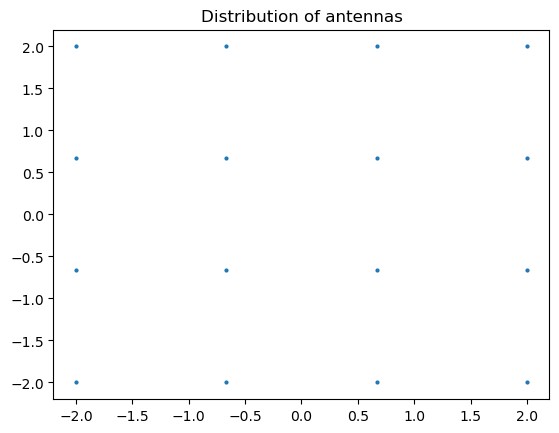

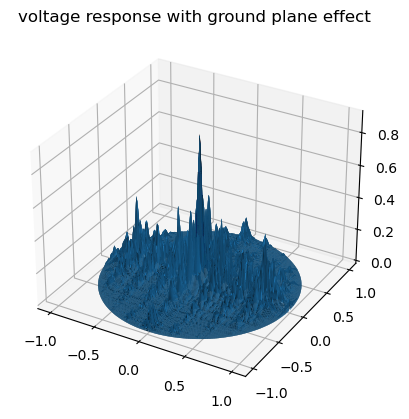

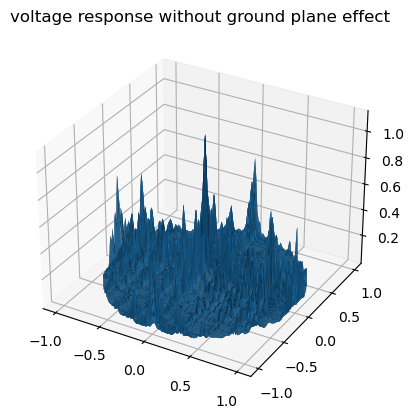

In [17]:
theta = np.deg2rad(np.arange(-90, 90))
phi = np.deg2rad(np.arange(-180, 180))
[theta, phi] = np.meshgrid(theta, phi)

f = (150*10**6) 
lamda = ((3*10**8)/f)
beta = (2*np.pi/lamda)

# Arrange 16 MWA antennas in a 4 m x 4 m square
n = 16
u, v = (lambda x: np.meshgrid(x, x))(np.linspace(-2, 2, 4))
u = u.flatten()
v = v.flatten()

plt.title("Distribution of antennas")
plt.plot(u, v, 'o', markersize=2)
plt.show()

l = np.sin(theta)*np.cos(phi)
m = np.sin(phi)*np.sin(theta)

delta = [0, 0] # Phase difference is now 2D

# We now consider things in two dimensions
chix = beta*np.array([l * dn for dn in u]) + delta[0]  # X-phase difference
chiy = beta*np.array([m * dn for dn in v]) + delta[1]  # Y-phase difference

afx = 1
afy = 1

for i in range(n):
    chinx = chix[i]
    chiny = chiy[i]

    afx = afx + np.exp(1j*(i+1)*chinx)
    afy = afy + np.exp(1j*(i+1)*chiny)

af = abs(afx*afy)/n**2

# Ground plane effect
antenna_height = 0.3
h = antenna_height/lamda
ground_plane_effect = np.sin(2*h*np.pi*np.cos(theta))

total_voltage = af*ground_plane_effect

# 3D plot of voltage response with the ground plane effect.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(l, m, total_voltage, rstride=1, cstride=1, antialiased=True)
plt.title('voltage response with ground plane effect')
plt.show()


# 3D plot of voltage response without any effects
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(l, m, af, rstride=1, cstride=1, antialiased=True)
plt.title('voltage response without ground plane effect')
plt.show()